# E: Introducción a la reducción de imágenes astronómicas

Basado en la [Guía de reducción de imágenes](https://www.astropy.org/ccd-reduction-and-photometry-guide/v/dev/notebooks/00-00-Preface.html) de ```AstroPy```.

En un mundo **ideal**, el valor de cada píxel (siendo un píxel un elemento de la matriz) sería directamente proporcional a la cantidad de luz que incidió sobre el píxel durante el tiempo que estuvo abierto el obturador de la cámara. Pero esto no es así y por tanto tenemos que realizar el proceso de reducción de imágenes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

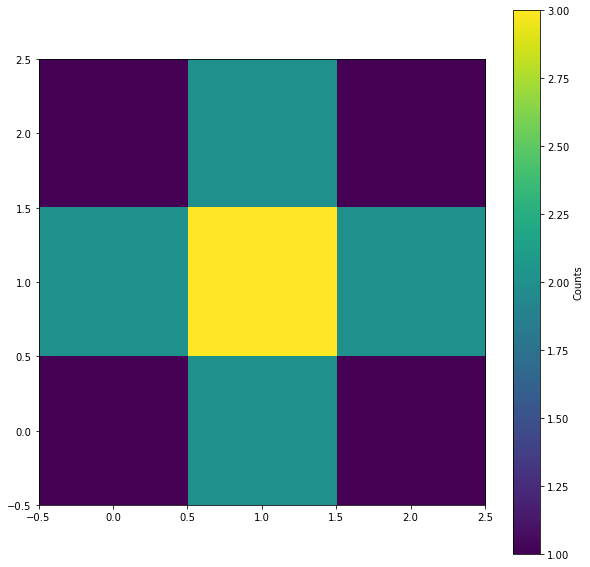

In [2]:
imagen_prueba = [[1,2,1], [2,3,2],[1,2,1]]

plt.figure("matrix", figsize=[10, 10])
plt.imshow(imagen_prueba, vmin=np.min(imagen_prueba), vmax=np.max(imagen_prueba), origin='lower')
plt.colorbar(label='Counts')
plt.show()

## ¿Cómo medimos la luz de objetos astronómicos? Cuentas, fotones y electrones

El número almacenado se denomina `Analog Digital Unit (ADU)` o *cuentas* debido a que la cámara convierte el voltaje analógico de cada píxel en cuentas numéricas. Estas cuentas son generadas a través del efecto fotoeléctrico cuando un fotón golpea el detector. El número de fotones que alcanzan el píxel está relacionado con las cuentas en el píxel por la ganancia. La ganancia generalmente la proporciona el fabricante de la cámara.

Hay que tener en cuenta que convertir las cuentas de imágenes sin procesar en fotones/electrones no es posible sólo multiplicando por la ganancia ya que las cuentas sin procesar incluyen artefactos que no provienen de objetos astronómicos.

### ¿Qué cuentas queremos y cuáles no?

- Se aplica un voltaje inicial llamado **_bias_** al chip CCD para garantizar que no haya cuentas negativas durante la lectura.

- Las cuentas se pueden generar en un píxel debido al movimiento térmico de los electrones en CCD. Enfriar un CCD reduce dicho movimiento térmico de los electrones, pero puede que no elimine por completo esta corriente oscura (**dark current**). En los CCDs modernos, la *dark current* a menudo se puede ignorar, excepto por una pequeña fracción de píxeles. Esta *dark current* generalmente tiene las unidades de electrones/segundo/píxel y depende en gran medida de la temperatura.

- Hay ruido de lectura intrínseco a la electrónica del CCD. Es imposible eliminar este ruido (está presente en todas las imágenes tomadas por la cámara), pero existen enfoques para minimizarlo. El ruido de lectura generalmente se informa en electrones, ya que puede depender de la temperatura. 

- Parte de la luz recibida por el telescopio es luz dispersa proveniente del cielo nocturno. La cantidad de **fondo de cielo** depende de la banda de paso del filtro, las condiciones atmosféricas y las fuentes de luz locales. 

- Aunque un chip CCD es bastante pequeño, es usual que los **rayos cósmicos** golpeen el chip, liberando carga que luego se convierte en cuentas. 

- Tanto los CCDs y las ópticas no son perfectos, por lo tanto necesitamos **flats** para corregir: 
    - El viñeteado
    - El polvo en el tren óptico.
    - Los píxeles muertos.

## Construyendo una imagen virtual

Vamos a construir una imagen sintética para poder explicar el tratamiento de reducción de imágenes sobre ella. Además así nos familiarizaremos con rutinas de ```Python``` y ```AstroPy```. Comenzaremos con la imagen más simple posible: una matriz de ceros:

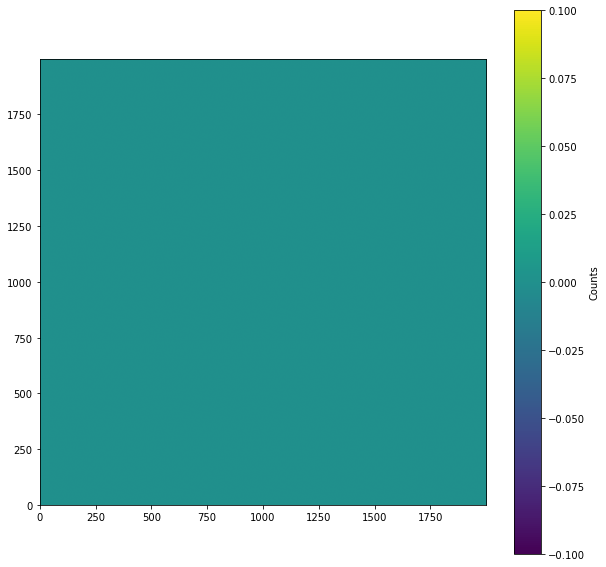

In [3]:
%matplotlib inline

imagen_sintetica = np.zeros([2000, 2000])

plt.figure("matrix", figsize=[10, 10])
plt.imshow(imagen_sintetica, vmin=np.min(imagen_sintetica), vmax=np.max(imagen_sintetica), origin='lower')
plt.colorbar(label='Counts')
plt.show()

### Generando ruido a mi imagen virtual

Generamos la función ruido de lectura en donde: 
  - ```amount```: es la cantidad de ruido de lectura en electrones
  - ```gain```: la ganancia de la cámara en electrones/ADU

In [4]:
def read_noise(image, amount, gain=1):
    """
    Generate simulated read noise.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the noise array should match.
    amount : float
        Amount of read noise, in electrons.
    gain : float, optional
        Gain of the camera, in units of electrons/ADU.
    """
    shape = image.shape
    
    noise = np.random.normal(scale=amount/gain, size=shape)
    
    return noise

En Python es muy sencillo operar sobre todos los píxeles de una imagen de una vez: podemos usar los operadores clásicos como la suma (```+```), resta (```-```), etc:

In [5]:
ruido = imagen_sintetica + read_noise(imagen_sintetica, 5)
imagen_sintetica, ruido

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([[ 2.45401465,  2.09290165, -0.70869772, ...,  4.95176345,
         -1.96976604,  3.68007833],
        [-2.79645545,  5.42373806, -0.98836528, ..., -7.90061759,
         -1.26628981,  8.60730303],
        [-3.42546408,  6.99096573, -4.03014551, ..., 10.18166343,
         -1.43345   ,  0.7268705 ],
        ...,
        [ 4.59879083,  5.32993546, -0.43306614, ..., 12.7828882 ,
          1.40487924,  1.11981693],
        [-2.07438543,  4.47514043, -4.1816097 , ..., -0.33939435,
         -0.99095184,  1.10506246],
        [ 0.57507611, -1.69132373,  4.3538104 , ..., -3.93263786,
          9.90139066,  2.56612586]]))

Para no repetir el proceso de ```matplotlib``` para visualizar las imágenes genero una función ```mostrar()```

In [6]:
def mostrar(imagen, vmin_valor, vmax_valor):
    """
    
    Parameters
    ----------
    
    image: numpy array
        Imagen que quiero visualizar.
    
    vmin_valor : float
        Cantidad de cuentas minima.
    
    vmax_valor : float
        Cantidad de cuentas maxima.
    """
    %matplotlib inline
    plt.figure("matrix", figsize=[10, 10])
    plt.imshow(imagen, vmin=vmin_valor, vmax=vmax_valor, origin='lower')
    plt.colorbar(label='Counts')
    return plt.show()

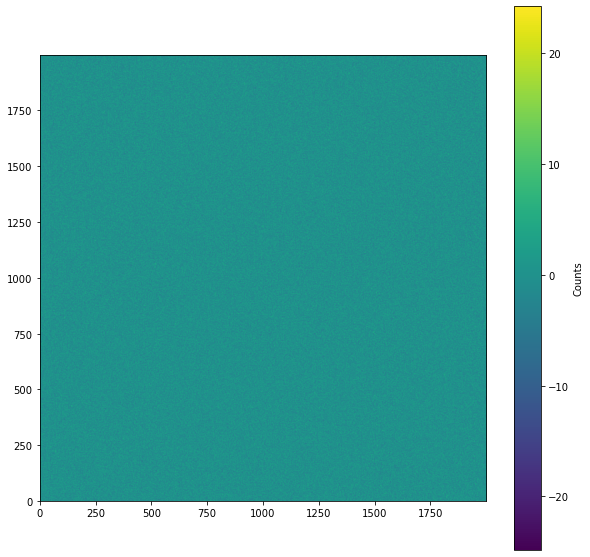

In [7]:
mostrar(ruido, np.min(ruido), np.max(ruido))

### Generando un *bias* virtual

El *bias* es un voltaje de compensación que se agrega a cada píxel de la imagen para garantizar que siempre se obtienen cuentas positivas. 

En la imagen generada de ruido, algunas cuentas son positivas y otras negativas (distribución gaussiana centrada en cero). Sin embargo, los valores de píxel se leen de la electrónica como números positivos. Agregar un voltaje constante, que corresponde a un número positivo constante, asegura que incluso una imagen de ruido no tenga valores negativos.

El valor del *bias* es aproximadamente el mismo en todo el chip CCD, aunque no es raro tener columnas y píxeles defectuosos o "malos" en los que el nivel de *bias* se compensa constantemente con el resto del chip.

Para modelar una imagen *bias*, creamos una matriz uniforme y opcionalmente, agregamos algunas columnas "malas".

Las columnas defectuosas en un CCD suelen ser estables durante mucho tiempo. Esta estabilidad es la que permite corregir el efecto en imágenes reales.

Finalmente tenemos que tener en cuenta que el *bias* no depende del tiempo de exposición. Esto se debe a que una exposición de *bias* es una exposición "oficialmente" de 0 segundos en la que la cámara simplemente lee el chip:

In [8]:
def bias(imagen, valor, realista=False):
    """
    Generate simulated bias image.
    
    Parameters
    ----------
    
    image: numpy array
        Image whose shape the bias array should match.
    value: float
        Bias level to add.
    realistic : bool, optional
        If ``True``, add some columns with somewhat higher bias value (a not uncommon thing)
    """
    # añadimos un valor constante en todo el sensor para que las cuentas sean positivas
    bias = np.zeros_like(imagen) + valor
    
    # Para hacelo mas realista utilizaremos que este valor cambie en cada pixel, ya que si no tendriamos en todos los pixeles el mismo bias
    if realista:
        shape = imagen.shape
        number_of_colums = 5
        
        #Queremos una variación de aspecto aleatorio en el bias, pero a diferencia del ruido de lectura, el bias *no* debe cambiar de una imagen a otra, 
        #por lo que nos aseguramos de generar siempre los mismos números "aleatorios".
        
        rng = np.random.RandomState(seed=8392)  # 20180520
        columns = rng.randint(0, shape[1], size=number_of_colums) #columnas malas
        # Esto agrega un pequeño ruido aleatorio a los datos.
        col_pattern = rng.randint(0, int(0.1 * valor), size=shape[0])
        
        # Hacemos que las columnas elegidas sean un poco más brillantes que el resto 
        for c in columns:
            bias[:, c] = valor + col_pattern
            
    return bias

In [9]:
bias_virtual = bias(imagen_sintetica, 1100, realista=True)

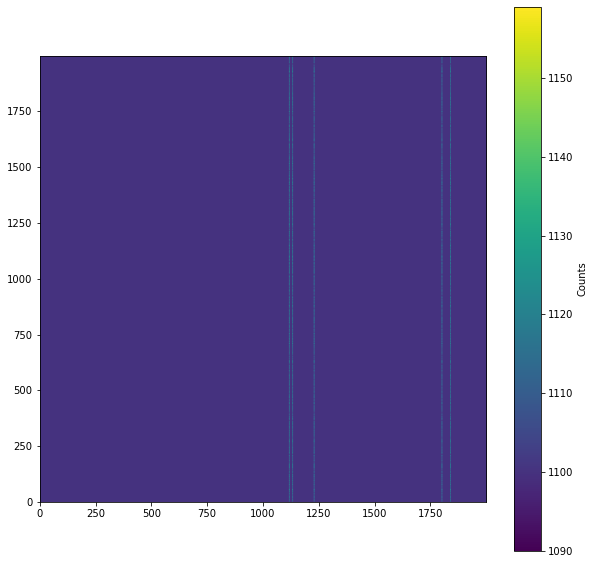

In [10]:
mostrar(bias_virtual, np.min(bias_virtual)-10, np.max(bias_virtual)-50)

Metemos algo de ruido aleatorio al *bias* generado

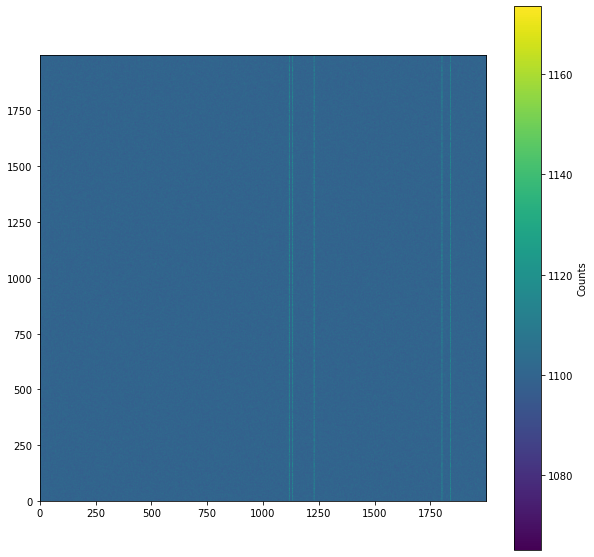

In [11]:
bias = ruido + bias_virtual
mostrar(bias, np.min(bias)-10, np.max(bias)-50)

### Generando un Dark virtual

La *dark current* depende de la temperatura del sensor. La cantidad de cuentas en darks también depende del tiempo de exposición. La *dark current* suele ser muy pequeña (0,1 electrones/píxel/segundo o menos).

Las cuentas se generan en esta función se calculan multiplicando la *dark current* de entrada por el tiempo de exposición de entrada después de convertir la unidad de *dark current* de electrones a conteos usando la ganancia.

Una pequeña fracción de los píxeles están "calientes": su dark current es mucho mayor que la del resto de los píxeles. Los píxeles calientes se modelan aquí eligiendo un subconjunto de píxeles para que tenga una dark current 10.000 veces mayor que la de entrada. Esto exagera el efecto para que esos píxeles sean más visibles.

La ubicación y la corriente de los píxeles calientes suelen ser estables durante largos períodos de tiempo, lo que hace que sea sencillo eliminar su efecto de las imágenes restándolos.

Un **_dark frame_** es una imagen tomada con el obturador de la cámara cerrado.

La siguiente función simula solo la corriente oscura, es decir, no simula el ruido de lectura que forma parte de cualquier *dark frame* real de un CCD.

Hay que tener en cuenta que la imagen *dark* simulada parece ruidosa aunque no incluye ruido de lectura. Esto se debe a que el número de electrones generados obedece a una distribución de Poisson. 

Definimos la función dark current.

In [12]:
def dark_current(image, current, exposure_time, gain=1.0, hot_pixels=False):
    """
    Simula dark current en un CCD, incluyendo opcionalmente píxeles calientes.
    
    Parámetros 
    ----------
    imagen: numpy array
         Imagen cuya forma debe coincidir con la imagen cientifica.
     corriente: floar
         Corriente oscura, en electrones/píxel/segundo.
     tiempo_de_exposición: float
         Duración de la exposición simulada, en segundos.
     ganancia: float
         Ganancia de la cámara, en unidades de electrones/ADU.
     """ 
    
    # corriente oscura para cada píxel; modificaremos la corriente para algunos píxeles si quieremoos píxeles calientes.
    base_current = current * exposure_time / gain
    
    # Esta generación de números aleatorios debería cambiar en cada llamada.
    dark_im = np.random.poisson(base_current, size=image.shape)
        
    if hot_pixels:
        # Configuraremos el 0,01% de los píxeles para que estén calientes; probablemente sea demasiado alto, pero debería garantizar que sean visibles.
        y_max, x_max = dark_im.shape
        
        n_hot = int(0.0001 * x_max * y_max)
        
        # Al igual que con el bias, queremos que los píxeles calientes estén siempre en los mismos lugares,
        # pero también queremos que parezcan estar distribuidos aleatoriamente. Así que establecemos una semilla de número aleatorio para asegurarnos de obtener siempre lo mismo.
        rng = np.random.RandomState(16201649)
        hot_x = rng.randint(0, x_max, size=n_hot)
        hot_y = rng.randint(0, y_max, size=n_hot)
        
        hot_current = 10000 * current
        
        dark_im[(hot_y, hot_x)] = hot_current * exposure_time / gain
    return dark_im

In [13]:
dark_exposure = 100 # segundos
dark_cur = 0.1 # electrones/píxel/segundo
dark_virtual = dark_current(imagen_sintetica, dark_cur, dark_exposure, hot_pixels=True)
dark = bias + dark_virtual

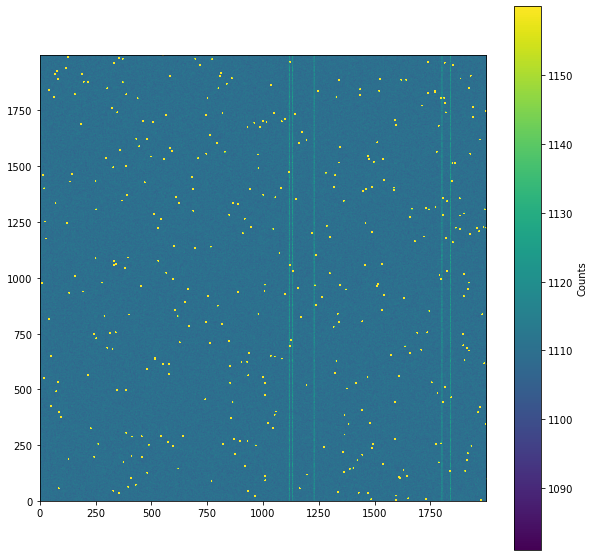

In [14]:
mostrar(dark, np.min(dark), np.median(dark)+50)

### Fondo de cielo (*sky background*)

La cantidad de fondo de cielo depende de las condiciones atmosféricas (humedad, presencia de nubes), las fuentes de luz en el cielo (la Luna) y las fuentes de luz en el área circundante (ciudades). Puede ser uniforme en toda la imagen o puede no serlo, según las condiciones.

La siguiente función genera un fondo de cielo. Cada vez que lo ejecutemos obtendremos resultados ligeramente diferentes ya que las cuentas de una fuente de luz siguen una distribución de Poisson.

La cantidad de fondo de cielo es directamente proporcional al tiempo de exposición. Sin embargo, en la función que usamos metemos el número deseado de cuentas de cielo. 

También podemos tener un degradado en el cielo, pero no lo usaremos en esta imagen virtual.

In [15]:
def sky_background(imagen, cuentas_cielo, gain=1):
    """
     Generamos un fondo de cielo
    
     Parámetros
     ----------
    
     imagen: numpy array
         Imagen cuya forma debe coincidir con la imagen cientifica.
     cuentas_cielo: float
         El valor para el número de cuentas del cielo.
     ganancia: float
         Ganancia de la cámara, en unidades de electrones/ADU.
    """
    sky_im = np.random.poisson(cuentas_cielo * gain, size=imagen.shape) / gain
    
    return sky_im

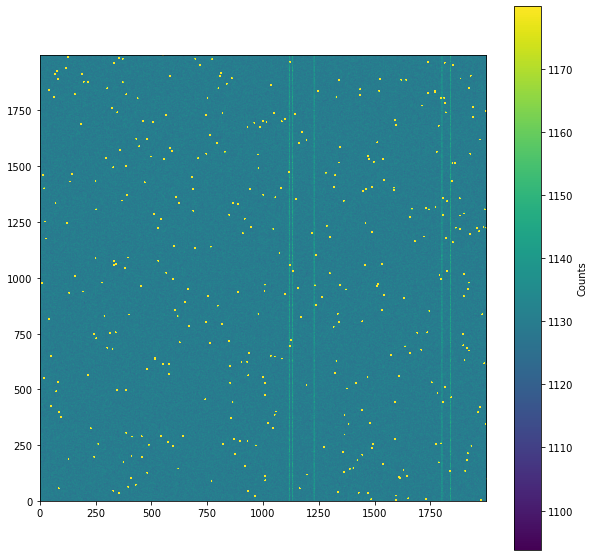

In [16]:
sky_level = 20
sky_virtual = sky_background(imagen_sintetica, sky_level)

sky = dark + sky_virtual
mostrar(sky, np.min(sky), np.median(sky)+50)

### Repasamos

El valor medio de los píxeles en la imagen "realista" (1130 más o menos), es la suma de:
- Nivel de *bias* (1100 recuentos)
- *Dark current* (10 recuentos, que es $0.1 e/seg/pix \times 100$ seg, dividido por la ganancia de $1 e/cuenta$)
- Cuentas para el fondo de cielo (20 cuentas)

### Añadimos algunas estrellas

Las "estrellas" que agregaremos a continuación son esencialmente solo fuentes gaussianas (redondas). Para ello usaremos la biblioteca ```photutils```:

```
conda install -c astropy photutils 
``` 

In [17]:
from photutils.datasets import make_random_gaussians_table, make_gaussian_sources_image
    
def stars(imagen, numero_estrellas, max_counts=10000, gain=1):
    """
    Añadiemos algunas estrellas.
    """
    # https://photutils.readthedocs.io/en/stable/_modules/photutils/datasets/make.html#make_100gaussians_image
    
    flux_range = [max_counts/10, max_counts]
    
    y_max, x_max = imagen.shape
    xmean_range = [0.1 * x_max, 0.9 * x_max]
    ymean_range = [0.1 * y_max, 0.9 * y_max]
    xstddev_range = [4, 4]
    ystddev_range = [4, 4]
    params = dict([('amplitude', flux_range),
                  ('x_mean', xmean_range),
                  ('y_mean', ymean_range),
                  ('x_stddev', xstddev_range),
                  ('y_stddev', ystddev_range),
                  ('theta', [0, 2*np.pi])])

    sources = make_random_gaussians_table(numero_estrellas, params,
                                          seed=12345)
    
    star_im = make_gaussian_sources_image(imagen.shape, sources)
    
    return star_im

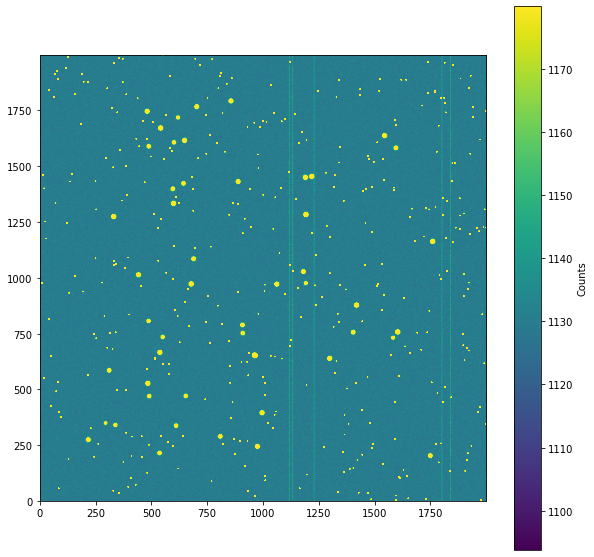

In [18]:
estrellas_virtuales = stars(imagen_sintetica, 50, max_counts=2000)
estrellas_reales = sky + estrellas_virtuales
mostrar(estrellas_reales, np.min(estrellas_reales), np.median(estrellas_reales)+50)

### Imagenes no uniformes (*flats*)

El viñeteo del tren óptico y el polvo en las lentes provocan artefactos en las imágenes astronómicas. A continuación simulamos dichos efectos:

In [19]:
import image_sim as isim

imagen = np.zeros([2000, 2000])
flat = isim.sensitivity_variations(imagen)

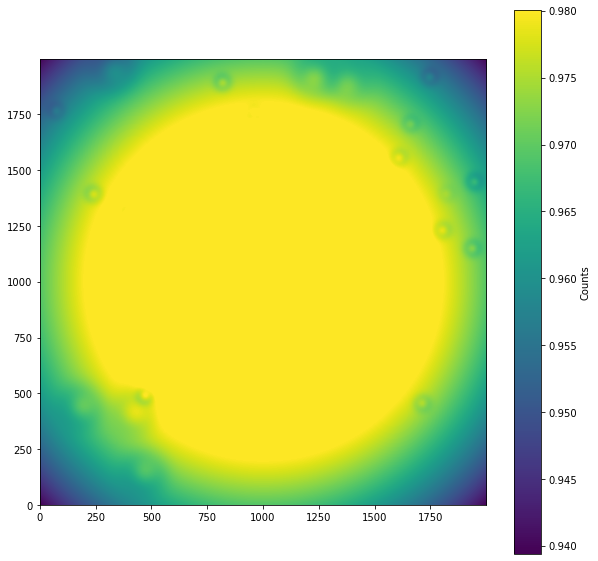

In [20]:
mostrar(flat, np.min(flat), np.median(flat))

Los donuts en la imagen es polvo en elementos como filtros que se encuentran en el tren óptico. 
El efecto son variaciones de sensibilidad que reducen la cantidad de luz que llega al sensor. 

En la ecuación anterior, eso significa que el *flat* multiplica solo la parte del cielo y las estrellas de la entrada: 
$$ image = bias + noise + dark current + flat\times(sky + stars ) $$

### Imagen final simulada

Podemos operar para obtener nuestra  imagen sintética final:

In [21]:
imagen_final = (sky_virtual + estrellas_virtuales)*flat + dark

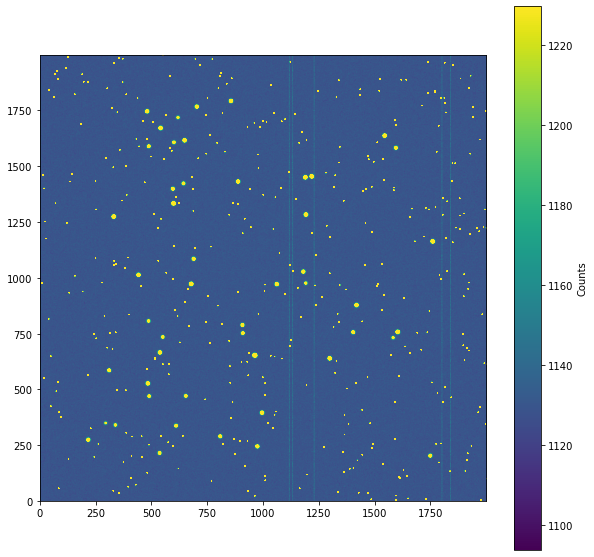

In [22]:
mostrar(imagen_final, np.min(imagen_final), np.median(imagen_final)+100)

Visualmente, no se ve diferente a la imagen final anterior, los efectos de las variaciones de sensibilidad normalmente no son evidentes en las imágenes en bruto.

Puede ver el efecto aumentando artificialmente el fondo del cielo.

In [23]:
imagen_final_2 = dark + flat * (isim.sky_background(imagen_sintetica, 100 * 20, gain=1) + estrellas_virtuales)

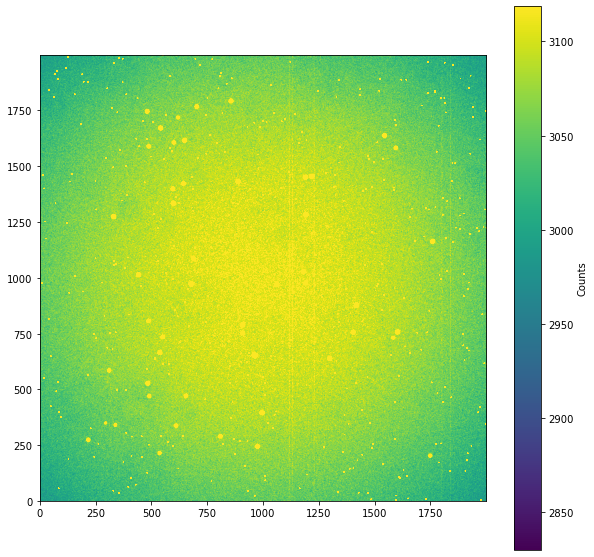

In [24]:
mostrar(imagen_final_2, np.min(imagen_final_2), np.median(imagen_final_2)+50)

Nuestra imagen simulada por lo tanto es: $$ imagen = bias + noise + dark current + flat\times(cielo + estrellas ) $$ 

y lo que queremos es: $estrellas = \frac{(imagen - bias - noise - dark current)}{flat} - cielo$.

En el siguiente *notebook* procederemos a calibrar nuestra imagen virtual